# **Projeto Extra: Computação Científica II - 2023**
##### **Data**: xx - 12/12/2023
##### **Alune**: Igor Lima Strozzi
##### **DRE**: 112040449

### Introduction
The main goal of this project is to solve the advection-diffusion equation using a finite differences scheme to figure out a convolution kernel and then make a simulation of the PDE by computing the next-in-time scalar field of the concentration $c$ by means of using PyTorch's `nn.Conv2d` to compute $c^{t+1} = c^{t} + \Delta t (A * c^{t})$.

### Introduction to the Advection-Diffusion Equation
The advection-diffusion equation is a fundamental partial differential equation (PDE) that describes the distribution of a scalar quantity (such as chemical concentration or temperature) within a physical system as it undergoes diffusion and advection.



### Meaning of each term
The general form of the equation is:
$$
\frac{\partial c}{\partial t} = D\nabla^2 c - \mathbf{v} \cdot \nabla c
$$
where:

* $c$ represents the concentration of the scalar quantity.
* $t$ is time.
* $D$ is the diffusion coefficient.
* $\nabla^2 c$ is the Laplacian of $c$, representing diffusion.
* $\mathbf{v}$ is the velocity field.
* $\nabla c$ is the gradient of $c$, representing advection.


### Discretization
The Laplacian $\nabla^2 c$ in two dimensions can be expanded into partial derivatives as:
$$
\nabla^2 c = \frac{\partial^2 c}{\partial x^2} + \frac{\partial^2 c}{\partial y^2}
$$
And the gradient $\nabla c$ in vector form is:
$$
\nabla c = \left( \frac{\partial c}{\partial x}, \frac{\partial c}{\partial y} \right)
$$

The time derivative can be discretized using a forward difference scheme as:
$$
\frac{\partial c}{\partial t} \approx \frac{c^{n+1} - c^n}{\Delta t}
$$
where superscripts denote time levels, and $\Delta t$ is the time step.

The spatial derivatives can be discretized using central difference schemes. For the second derivatives:
$$
\frac{\partial^2 c}{\partial x^2} \approx \frac{c_{i+1,j} - 2c_{i,j} + c_{i-1,j}}{\Delta x^2}
$$
$$
\frac{\partial^2 c}{\partial y^2} \approx \frac{c_{i,j+1} - 2c_{i,j} + c_{i,j-1}}{\Delta y^2}
$$
And for the first derivatives:
$$
\frac{\partial c}{\partial x} \approx \frac{c_{i+1,j} - c_{i-1,j}}{2\Delta x}
$$
$$
\frac{\partial c}{\partial y} \approx \frac{c_{i,j+1} - c_{i,j-1}}{2\Delta y}
$$


### Convolution kernels from discretizations
The 2D convolution kernel for the discretized diffusion term, calling $\frac{1}{\Delta x ^2} = \alpha_x$, and $\alpha_y$ analogously, is:
$$
D \cdot
\begin{bmatrix}
0 & \alpha_y & 0 \\
\alpha_x & -2(\alpha_x + \alpha_y) & \alpha_x \\
0 & \alpha_y & 0
\end{bmatrix}
$$

Using central differences for the advection term, the kernel is, calling $\beta_* = \sqrt\alpha_*$:
$$
\frac{1}{2} \cdot
\begin{bmatrix}
0 & -v_y \beta_y & 0 \\
-v_x \beta_x & 0 & v_x \beta_x \\
0 & v_y \beta_y & 0
\end{bmatrix}
$$

The combined kernel representing both diffusion and advection is obtained by summing the individual kernels:
$$A = 
\begin{bmatrix}
0 & D \alpha_y - \frac{v_y  \beta_y}{2} & 0 \\
D \alpha_x - \frac{v_x \beta_x}{2} & -2 (\alpha_x + \alpha_y) & D \alpha_x + \frac{v_x \beta_x}{2} \\
0 & D \alpha_y + \frac{v_y  \beta_x}{2} & 0
\end{bmatrix}
$$
We shall use this matrix as the convolution kernel to update the concentration field in $c^{t+1} = c^{t} + \Delta t (A * c^{t})$.

In [78]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D


# Set the simulation parameters
delta_x = 0.2
delta_y = 0.2
delta_t = 0.01
D = 0.5  # Diffusion coefficient
v_x = 5
v_y = 5
steps = 500  # Number of steps to simulate
size = 128 # Size of the 2D grid
alpha_x = 1 / delta_x ** 2
alpha_y = 1 / delta_y ** 2
beta_x =  1 / delta_x
beta_y = 1 / delta_y
GAUSSIAN_IC = True  # Whether to use a Gaussian as the initial condition

# Check if the simulation will be stable
if D * delta_t / (delta_x**2) >= 0.5 or D * delta_t / (delta_y**2) >= 0.5:
    raise ValueError("The simulation will be unstable. Please adjust the parameters.")


In [79]:
def initialize_field(gaussian_ic = True):
    if not gaussian_ic:
        # Initialize the concentration field with random values
        c = torch.rand((1, 1, size, size), requires_grad=False)
    else:
        # Initialize the concentration field with a 2D Gaussian centered at the middle of the domain
        x = np.linspace(-size//2, size//2, size)
        y = np.linspace(-size//2, size//2, size)
        x, y = np.meshgrid(x, y)
        sigma = size / 16  # Standard deviation of the Gaussian
        gaussian = np.exp(-(x**2 + y**2) / (2 * sigma**2))
        c = torch.tensor(gaussian, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    return c

In [80]:

# Define the combined kernel for both diffusion and convection
combined_kernel = torch.tensor([
    [0, D * alpha_y - (v_y * beta_y) / 2, 0],
    [D * alpha_x - (v_x * beta_x ) / 2, -2*D * (alpha_x + alpha_y), D * alpha_x + (v_x * beta_x ) / 2],
    [0, D * alpha_y + (v_y * beta_y) / 2, 0]
], dtype=torch.float32).reshape((1, 1, 3, 3))


In [81]:

# Define the convolution operation with circular padding
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=size,
                 stride=1, padding=1, padding_mode='circular', bias=False)

conv.weight.data = combined_kernel
conv.weight.requires_grad = False


In [82]:
# Simulation function
def simulate(c, conv, steps):
    for _ in range(steps):
        # Apply the convolution to get the rate of change
        dc_dt = conv(c)
        # Update the concentration field
        c += dc_dt * delta_t
    return c


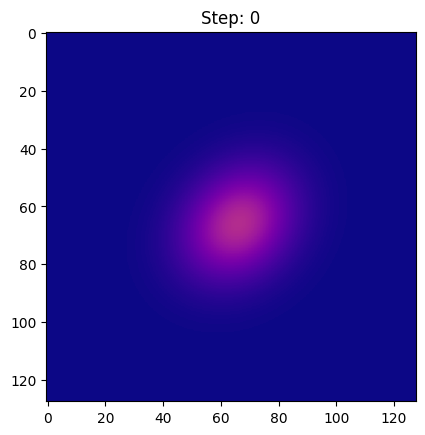

In [83]:
# Save 2D heatgram animation
GAUSSIAN_IC = True  # Whether to use a Gaussian as the initial condition
c = initialize_field(gaussian_ic = GAUSSIAN_IC)

# Animate the simulation
fig, ax = plt.subplots()

def animate(i):
    global c
    c = simulate(c, conv, 1)  # Update the field
    ax.clear()
    ax.imshow(c.detach().numpy()[0, 0], cmap='plasma', vmax=1)
    ax.set_title(f"Step: {i}")
    
ani = animation.FuncAnimation(fig, animate, frames=steps, interval=25, repeat=False)


ani.save('simulation_2d_gaussian_ic.mp4'if GAUSSIAN_IC else 'simulation_2d_random_ic.mp4')

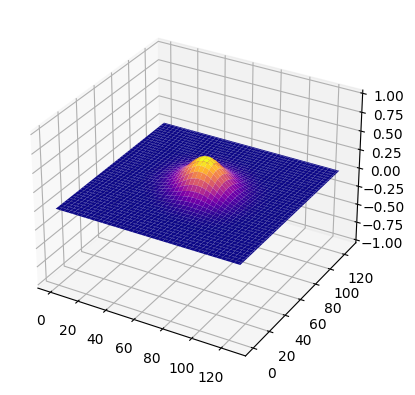

In [84]:
# Save 2D surface evolution animation
c = initialize_field(gaussian_ic = GAUSSIAN_IC)
# Create a meshgrid for plotting
X, Y = np.meshgrid(np.linspace(0, size-1, size), np.linspace(0, size-1, size))

# Set up the figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim(- 1, 1)
# Initial plot
surf = ax.plot_surface(X, Y, c.detach().numpy()[0, 0], cmap='plasma')
# surf.set_zlim()
# Animation update function
def update_plot(frame, c, surf):
    global conv
    # Update the concentration field
    c = simulate(c, conv, 1)  # Simulate one step
    ax.clear()
    ax.set_zlim(- 1, 1)
    # Update the surface plot
    surf = ax.plot_surface(X, Y, c.detach().numpy()[0, 0], cmap='plasma')
    # surf.set_clim(-1, 3)
    return surf,

# Animate the simulation
ani = animation.FuncAnimation(fig, update_plot, fargs=(c, surf), frames=steps, interval=20, blit=False)

# Show the animation
# plt.show()

ani.save('simulation_3d_gaussian_ic.mp4'if GAUSSIAN_IC else 'simulation_3d_random_ic.mp4');

### Conclusions

As we can see in the animations, even more explicitly in the second one, this convolutional approach, with the deduced convolutional kernels, indeed reproduces the expected dynamics, of both transport through a velocity field (here asssume not changing with time) and diffusion through the medium.